import các thư viện cần thiết để sử dụng

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import LearningRateScheduler

2025-05-20 10:24:56.401190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747736696.660659      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747736696.732780      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Khai báo các biến cấu hình (hyperparameters) cần thiết, sử dụng trong lúc huấn luyện

In [ ]:
BATCH_SIZE       = 32
IMG_SIZE         = (224, 224)
NUM_CLASSES      = 9
DATA_DIR         = '/kaggle/input/data-aquatic'
VALIDATION_SPLIT = 0.10
TEST_SPLIT       = 0.05
SEED             = 123

Quét dữ liệu ảnh từ dataset và gán nhãn số (label) tương ứng cho từng ảnh Sắp xếp tên lớp theo thứ tự alpha

In [ ]:
file_paths, labels = [], []
class_names = sorted(os.listdir(DATA_DIR))
class_to_index = {n:i for i,n in enumerate(class_names)}
nb_classes = len(class_to_index)

In ra số lượng class và danh sách class gồm label và class_name

In [ ]:
print(f"Number of classes: {nb_classes}")
print("Class names:")
for i, name in enumerate(class_names):
    print(f"{i}: {name}")

Number of classes: 9
Class names:
0: Crabs_
1: Lobster_
2: Octopus_
3: Otter_
4: Puffers_
5: Sea Urchins_
6: Seahorse_
7: Squid_
8: Starfish_


Vẽ biểu đồ phân bố số lượng ảnh theo từng class trong dataset

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


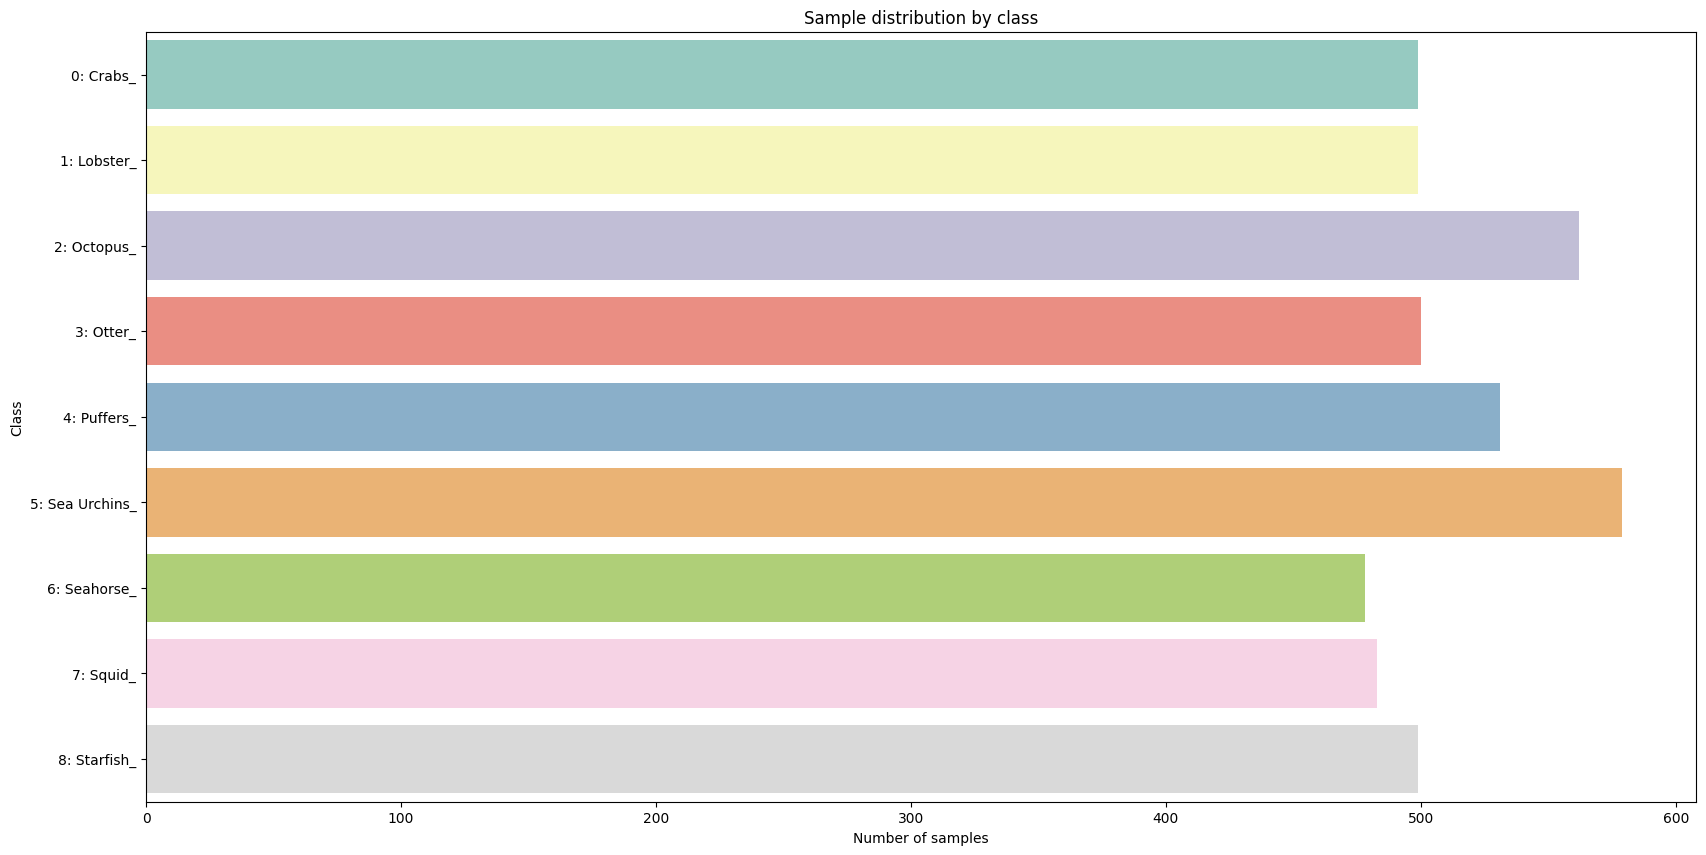

In [ ]:
plt.figure(figsize=(20, 10))
x_vals = [len(os.listdir(os.path.join(DATA_DIR, class_name))) for class_name in class_names]
y_labels = [f"{class_to_index[class_name]}: {class_name}" for class_name in class_names]
sns.barplot(x=x_vals, y=y_labels, palette='Set3')
plt.xlabel('Number of samples')
plt.ylabel('Class')
plt.title('Sample distribution by class')
plt.show()

Hiển thị mỗi class 3 ảnh ngẫu nhiên để kiểm tra trực quan dữ liệu trong dataset

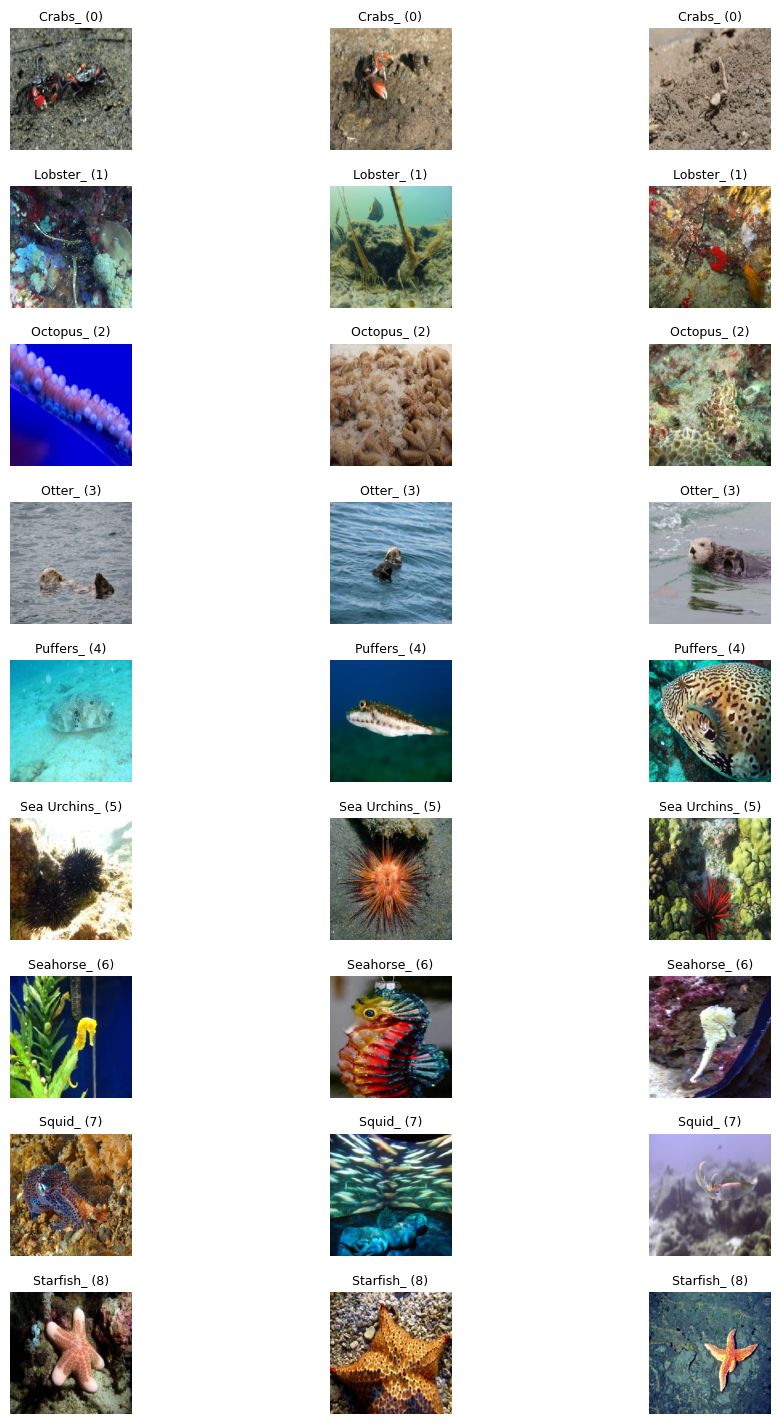

In [ ]:
SAMPLES_PER_CLASS = 3

plt.figure(figsize=(12, nb_classes * 2))  # giảm chiều rộng và chiều cao tổng thể

for i, cls in enumerate(class_names):
    cls_dir = os.path.join(DATA_DIR, cls)
    all_images = [f for f in os.listdir(cls_dir) if f.lower().endswith(('jpg','png','jpeg'))]

    sample_images = np.random.choice(all_images, min(SAMPLES_PER_CLASS, len(all_images)), replace=False)

    for j, img_name in enumerate(sample_images):
        img_path = os.path.join(cls_dir, img_name)
        img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
        img_array = tf.keras.utils.img_to_array(img).astype('uint8')

        ax = plt.subplot(nb_classes, SAMPLES_PER_CLASS, i * SAMPLES_PER_CLASS + j + 1)
        ax.imshow(img_array)
        ax.axis('off')
        ax.set_title(f"{cls} ({class_to_index[cls]})", fontsize=9)

plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

Tạo tập huấn luyện và tập kiểm tra

In [ ]:
for cls in class_names:
    cls_dir = os.path.join(DATA_DIR, cls)
    for fname in os.listdir(cls_dir):
        if fname.lower().endswith(('jpg','png','jpeg')):
            file_paths.append(os.path.join(cls_dir, fname))
            labels.append(class_to_index[cls])

ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
ds = ds.shuffle(len(file_paths), seed=SEED)

val_size = int(len(file_paths) * VALIDATION_SPLIT)
test_size = int(len(file_paths) * TEST_SPLIT)

val_ds = ds.take(val_size)
test_ds = ds.skip(val_size).take(test_size)
train_ds = ds.skip(val_size + test_size)

I0000 00:00:1747736715.167836      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Tóm tắt số lượng ảnh trong tập train, validation và test

In [ ]:
total_images = len(file_paths)
train_size = total_images - val_size - test_size

print(f"Total number of images: {total_images}")
print(f"Number of training images: {train_size}")
print(f"Number of validation images: {val_size}")
print(f"Number of test images: {test_size}")

Total number of images: 4630
Number of training images: 3936
Number of validation images: 463
Number of test images: 231


Tiền xử lý ảnh, tăng cường dữ liệu bằng cách tạo layer xoay ngẫu nhiên trong khoảng 20 độ

In [ ]:
# Preprocess & Augmentation
# tạo layer xoay
rotation_layer = layers.RandomRotation(factor=0.2)

def preprocess(path, label, training):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    if training:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.1)
        img = tf.image.random_contrast(img, 0.9, 1.1)
        img = rotation_layer(img)                # áp dụng xoay ở đây
    img = (tf.cast(img, tf.float32) / 127.5) - 1.0
    return img, label

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x,y: preprocess(x,y,True),
                        num_parallel_calls=AUTOTUNE) \
                   .batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds   = val_ds.map(lambda x,y: preprocess(x,y,False),
                      num_parallel_calls=AUTOTUNE) \
                 .batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.map(lambda x, y: preprocess(x, y, False),
                      num_parallel_calls=AUTOTUNE) \
                 .batch(BATCH_SIZE).prefetch(AUTOTUNE)

Xây dựng kiến trúc ResNet18 từ đầu

In [ ]:

#ResNet-18
def conv_bn_relu(x, filters, kernel_size=3, strides=1):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)

def residual_block(x, filters, downsample=False):
    strides = 2 if downsample else 1
    shortcut = x

    x = conv_bn_relu(x, filters, strides=strides)
    x = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if downsample:
        shortcut = layers.Conv2D(filters, 1, strides=2, padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    return layers.ReLU()(x)

def build_resnet18(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    for filters in [64, 128, 256, 512]:
        x = residual_block(x, filters, downsample=(filters!=64))
        x = residual_block(x, filters)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

model = build_resnet18(IMG_SIZE + (3,), NUM_CLASSES)

Hiển thị kiến trúc mô hình vừa xây dựng

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,408 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 64)     │         36,864 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 56, 56, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 64)     │         36,864 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 56, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 56, 56, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 64)     │         36,864 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 56, 56, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 64)     │         36,864 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 11,190,729 (42.69 MB)

 Trainable params: 11,181,129 (42.65 MB)

 Non-trainable params: 9,600 (37.50 KB)

Điều chỉnh learning rate qua từng giai đoạn (ở đây là mỗi 10 epoch 1 lần giảm)

In [ ]:
def step_decay(epoch):
    initial_lr = 1e-3
    drop = 0.5
    epochs_drop = 10
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

In [ ]:
scheduler = LearningRateScheduler(step_decay, verbose=1)

Biên dịch mô hình

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Train mô hình

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=80,
    verbose=1,
    callbacks=scheduler
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/80


I0000 00:00:1747736733.574812      97 service.cc:148] XLA service 0x7a8ce000c9f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747736733.575885      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747736735.267767      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/123 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - accuracy: 0.0391 - loss: 4.0958  

I0000 00:00:1747736744.065622      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


123/123 ━━━━━━━━━━━━━━━━━━━━ 52s 215ms/step - accuracy: 0.2506 - loss: 2.5386 - val_accuracy: 0.2419 - val_loss: 2.2990 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - accuracy: 0.3288 - loss: 1.8280 - val_accuracy: 0.3197 - val_loss: 2.1092 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.3664 - loss: 1.7531 - val_accuracy: 0.1922 - val_loss: 3.0438 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.3973 - loss: 1.6957 - val_accuracy: 0.2333 - val_loss: 3.5511 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/80
123/123 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 0.4158 - loss: 1.6405 - val_accuracy: 0.3607 - val_loss: 1.9200 - le

Lưu mô hình cuối cùng

In [ ]:
model.save('/kaggle/working/my_model.h5')

Vẽ biểu đồ tiến trình huấn luyện của hai tập train và validation dựa vào hai giá trị:

Accuracy
Loss

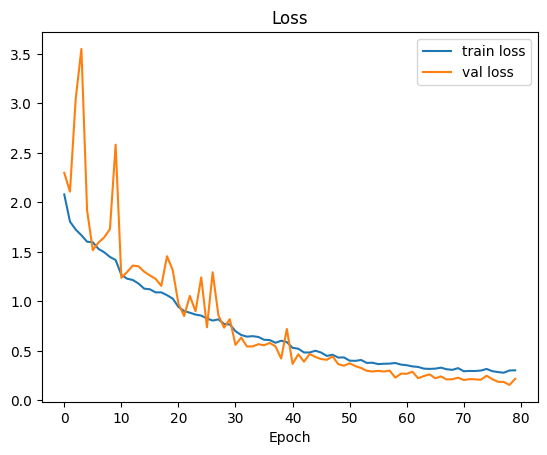

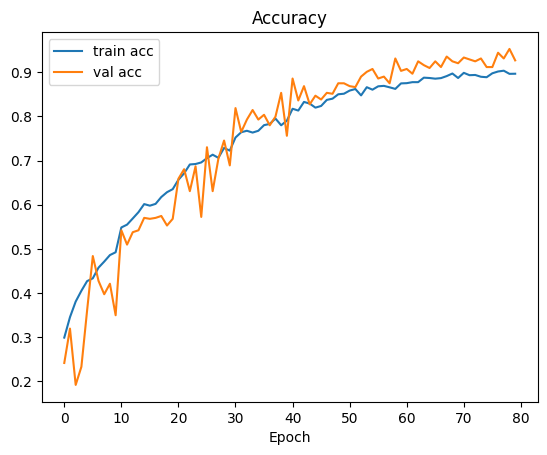

In [ ]:
def plot_history(h):
    plt.figure()
    plt.plot(h.history['loss'], label='train loss')
    plt.plot(h.history['val_loss'], label='val loss')
    plt.legend(); plt.title('Loss'); plt.xlabel('Epoch'); plt.show()

    plt.figure()
    plt.plot(h.history['accuracy'], label='train acc')
    plt.plot(h.history['val_accuracy'], label='val acc')
    plt.legend(); plt.title('Accuracy'); plt.xlabel('Epoch'); plt.show()

plot_history(history)

Bảng đánh giá kết quả huấn luyện mô hình trên tập Validation, in ra bảng báo cáo phân loại cho từng class. Độ chính xác đạt được trên tập Validation là 92%

In [ ]:
y_true = []
y_pred = []
for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
              precision    recall  f1-score   support

      Crabs_       0.98      1.00      0.99        51
    Lobster_       0.95      0.93      0.94        43
    Octopus_       0.86      0.81      0.84        69
      Otter_       0.98      1.00      0.99        56
    Puffers_       0.88      0.86      0.87        50
Sea Urchins_       0.94      1.00      0.97        58
   Seahorse_       0.89      0.89      0.89        44
 

Ma trận nhầm lẫn (confusion matrix) trực quan, cho biết chi tiết kết quả dự đoán của mô hình trên từng lớp

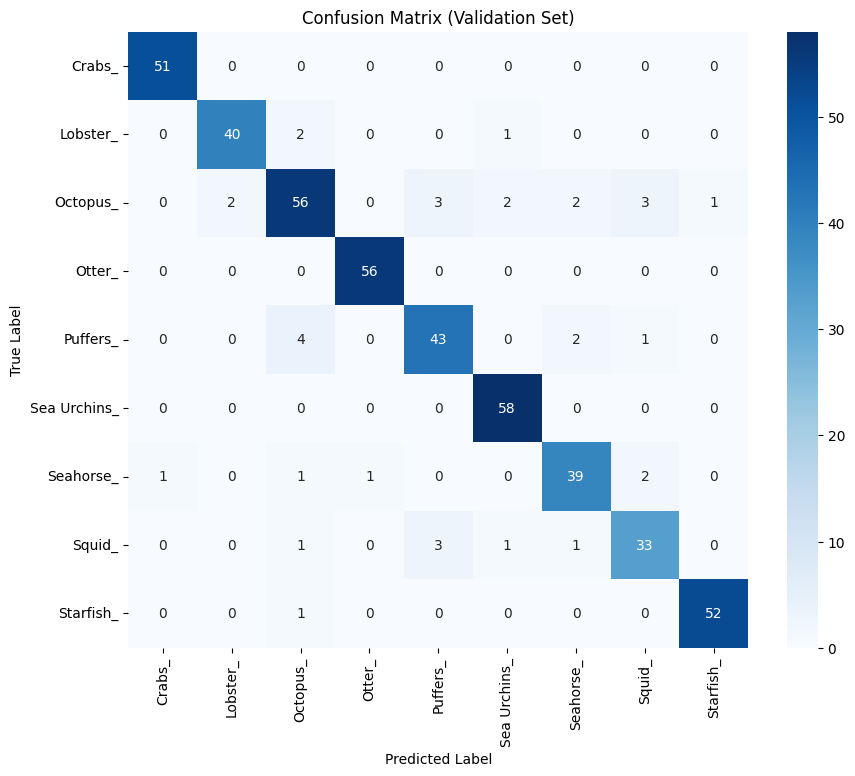

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

Thực hiện kiểm tra đánh giá trên tập test

In [ ]:
def evaluate_with_report(model, test_ds, class_names):
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (Test Set)")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Classification Report:
              precision    recall  f1-score   support

      Crabs_       1.00      1.00      1.00        21
    Lobster_       0.83      0.83      0.83        24
    Octopus_       0.85      0.85      0.85        26
      Otter_       1.00      1.00      1.00        29
    Puffers_       0.90      0.83      0.86        23
Sea Urchins_       0.92      0.96      0.94        25
   Seahorse_       0.93      0.93      0.93        29
      Squid_       0.92      0.88      0.90        25
   Starfish_       0.94      1.00      0.97        29

    accuracy                           0.92       231
   macro avg       0.92      0.92      0.92       231
weighted avg       0.92 

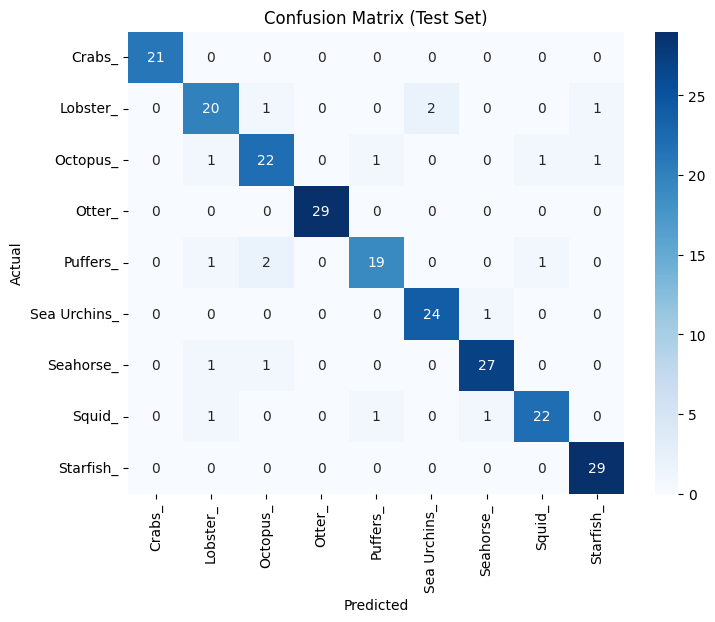

In [ ]:
evaluate_with_report(model, test_ds, class_names)